# Plant Pathology

In [1]:
from fastai2.vision.all import *
from fastai2.callback.all import *

In [2]:
from efficientnet_pytorch import EfficientNet

In [3]:
from sklearn.metrics import roc_auc_score
from collections import Counter

# Load the data

In [4]:
path = Path('data/')
path.ls()

(#5) [Path('data/.ipynb_checkpoints'),Path('data/test.csv'),Path('data/sample_submission.csv'),Path('data/images'),Path('data/train.csv')]

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


**Plot distribution of the classes in the dataset**

In [6]:
idx_labels = {}

In [7]:
counter = Counter()

for idx, row in df.iterrows():
    label = row.loc[row==1].index[0]
    counter[label] += 1
    idx_labels[idx] = label

In [8]:
counter

Counter({'scab': 592, 'multiple_diseases': 91, 'healthy': 516, 'rust': 622})

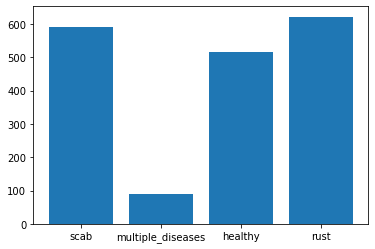

In [9]:
plt.bar([0, 1, 2, 3], counter.values())
plt.xticks([0, 1, 2, 3], counter.keys());

**Let's oversample from the minority classes**

In [10]:
def oversample(df: pd.DataFrame, cond, limit:int):
    grouped = df.groupby(cond)
    lst = []
    
    for name, group in grouped:
        if len(group) < limit: 
            lst.append(group.sample(limit, replace=True))
        else:
            lst.append(group)
    return pd.concat(lst)

In [11]:
limit = max(counter.values())
limit

622

In [12]:
df_oversampled = oversample(df, idx_labels, limit)
df_oversampled.head()

,image_id,healthy,multiple_diseases,rust,scab
1286,Train_1286,1,0,0,0
1286,Train_1286,1,0,0,0
1002,Train_1002,1,0,0,0
1614,Train_1614,1,0,0,0
446,Train_446,1,0,0,0


**Sanity check**

In [13]:
counter = Counter()

for idx, row in df_oversampled.iterrows():
    label = row.loc[row==1].index[0]
    counter[label] += 1

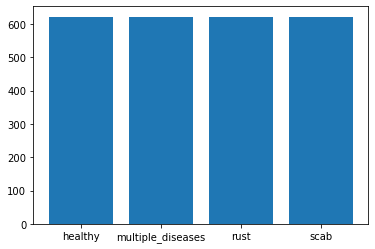

In [14]:
plt.bar([0, 1, 2, 3], counter.values())
plt.xticks([0, 1, 2, 3], counter.keys());

## Define DataLoaders

In [15]:
dsets = Datasets(df_oversampled)

In [16]:
dsets.train[0]

(image_id             Train_1286
 healthy                       1
 multiple_diseases             0
 rust                          0
 scab                          0
 Name: 1286, dtype: object,)

Getting a single item in the dataset just returns a row from the dataframe, let's define functions to return the appropriate data forms

In [44]:
def get_x(r): return path/'images'/f'{r["image_id"]}.jpg'
def get_y(r): return r.loc[r==1].index[0]

In [45]:
tfms_x = [get_x]
tfms_y = [get_y]

In [46]:
dsets = Datasets(df_oversampled, tfms=[tfms_x, tfms_y])

In [47]:
dsets.train[0]

(Path('data/images/Train_1286.jpg'), 'healthy')

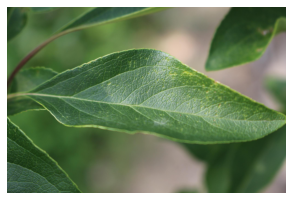

In [50]:
img = PILImage.create(dsets.train[0][0])
img.show();

Ok so now we have the path to each image and their corresponding labels

In [62]:
tfms_x = [get_x, PILImage.create]
tfms_y = [get_y, Categorize()]

In [63]:
dsets = Datasets(df_oversampled, tfms=[tfms_x, tfms_y], splits=splits)

In [64]:
dls = dsets.dataloaders(bs=64, 
    after_item=[Resize(460), ToTensor],
    after_batch=[IntToFloatTensor,
                 *aug_transforms(size=224, min_scale=0.75, flip_vert=True),
                 Normalize.from_stats(*imagenet_stats)])

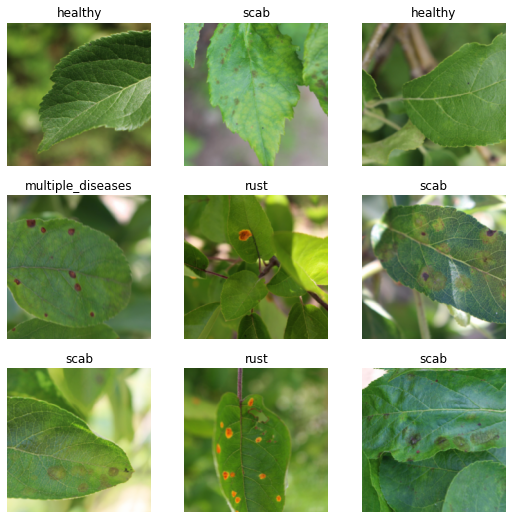

In [67]:
dls.show_batch()